In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import os
from random import shuffle
from random import choices
from glob import glob

In [2]:
#размер входного изображения сети
IMG_SIZE = (224, 224)

train_files = glob('data/train/train/*.jpg')
test_files = glob('data/test/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size = IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size = 32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

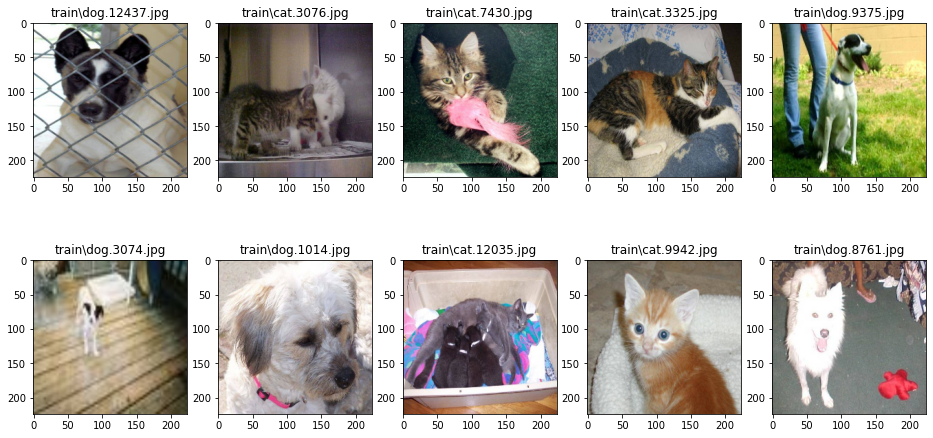

In [3]:
#визуализация исходных картинок

%matplotlib inline

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(choices(train_files, k = 10), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [4]:
#Загружаем предобученную модель
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [21]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [47]:
#добавляем слои
x = base_model.output
x = tf.keras.layers.Dense(5000, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  
                          activation='sigmoid', 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [48]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [49]:
model.compile(optimizer='adam', 
              loss=['binary_crossentropy'], 
              metrics=['accuracy'])

In [54]:
val_samples = 5 

shuffle(train_files) 
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,
          epochs=12, 
          validation_data=validation_data,
          )

Epoch 1/12
10/10 [==============================] - 38s 4s/step - loss: 0.6144 - accuracy: 0.9812 - val_loss: 0.1406 - val_accuracy: 1.0000
Epoch 2/12
10/10 [==============================] - 37s 4s/step - loss: 0.4102 - accuracy: 0.9875 - val_loss: 0.1405 - val_accuracy: 1.0000
Epoch 3/12
10/10 [==============================] - 37s 4s/step - loss: 0.3169 - accuracy: 0.9844 - val_loss: 0.2940 - val_accuracy: 0.8000
Epoch 4/12
10/10 [==============================] - 37s 4s/step - loss: 0.4146 - accuracy: 0.9844 - val_loss: 0.1421 - val_accuracy: 1.0000
Epoch 5/12
10/10 [==============================] - 37s 4s/step - loss: 0.5720 - accuracy: 0.9844 - val_loss: 0.1419 - val_accuracy: 1.0000
Epoch 6/12
10/10 [==============================] - 37s 4s/step - loss: 0.1817 - accuracy: 0.9875 - val_loss: 0.1420 - val_accuracy: 1.0000
Epoch 7/12
10/10 [==============================] - 37s 4s/step - loss: 0.3229 - accuracy: 0.9875 - val_loss: 3.9226 - val_accuracy: 0.8000
Epoch 8/12
10/10 [==

In [55]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

In [21]:
len(test_pred)

12500

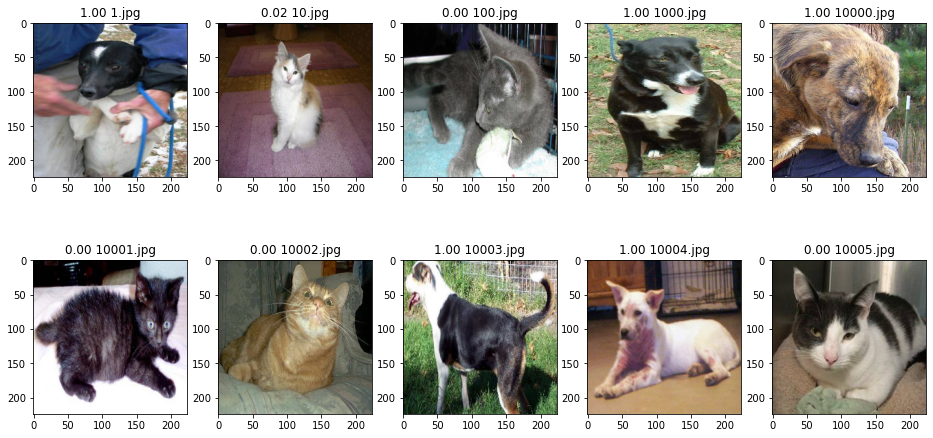

In [22]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [56]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))